In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import ast 
from tqdm import tqdm
from PIL import Image

In [4]:
train = pd.read_csv('./csv_data/train.csv')
valid = pd.read_csv('./csv_data/valid.csv')
annotations =  pd.read_csv('./csv_data/train/annotations_train.csv')
images =  pd.read_csv('./csv_data/train/images_train.csv')

- 각각의 비엔나 코드 당 이미지의 개수 확인 (불균형한 비율로 존재하고 있다)

In [8]:
images['Vienna_Code'].value_counts()

260418    61257
270508    56661
261112    53948
260118    42546
260409    33899
          ...  
080711     1027
051113     1015
241720     1013
260212     1002
030702     1001
Name: Vienna_Code, Length: 392, dtype: int64

- 하나의 이미지가 가지고 있는 비엔나 코드의 개수 확인 (최대 9개 최소 1개)

In [18]:
images['id'].value_counts()

4020200038747    9
4020190198330    8
4020190075430    8
4020190158227    8
4020190158233    8
                ..
4020120049622    1
4020110047600    1
4020110029383    1
4020110029378    1
4120080008750    1
Name: id, Length: 898023, dtype: int64

- 하나의 이미지가 가지고 있는 bbox의 개수 (최대 186 최소 1개인데 위에서 최대 비엔나 코드랑 비교하면 중복된 클래스의 bbox라는 걸 알 수 있다)

In [15]:
annotations['image_id'].value_counts()

4020180122700    186
4020180121696    186
4020110063959    126
4020130073173    111
4020140023003    105
                ... 
4019680004098      1
4019680004100      1
4019680004101      1
4019680004102      1
4120070020622      1
Name: image_id, Length: 890065, dtype: int64

- bbox를 최소로 가지고 있는 클래스 확인 (17개밖에 가지고 있지 않는 것이 존재하고 클래스 개수랑 비교했을 때 차이가 많이 나는 것 확인)

In [16]:
temp1 = pd.DataFrame(annotations['name'].value_counts()).reset_index()
temp1.columns = ['name', 'count']

temp1

,name,count
0,도형 요소와 연결되거나 도형 요소를 포함하고 있는 문자 [Note] 사물 또는 자연...,70168
1,곡선 또는 띠 (A- 26-11-13 제외),65428
2,하나 이상의 문자를 포함하는 사변형,62230
3,도안화(양식화)된 나뭇잎,56735
4,하나 이상의 문자를 포함하는 원 또는 타원,46409
...,...,...
384,체크 표시,1012
385,"탱거드(금속제 큰 맥주잔), 손잡이가 달린 유리잔",987
386,평행육면체,974
387,"가지, 오이, 피클용 오이, 파프리카",436


In [21]:

temp2 = pd.DataFrame(images['name'].value_counts()).reset_index()
temp2.columns = ['name', 'count']

temp2

,name,count
0,하나 이상의 문자를 포함하는 사변형,61257
1,도형 요소와 연결되거나 도형 요소를 포함하고 있는 문자 [Note] 사물 또는 자연...,56661
2,곡선 또는 띠 (A- 26-11-13 제외),53948
3,하나 이상의 문자를 포함하는 원 또는 타원,42546
4,병렬로 놓이거나 접하거나 또는 교차된 수 개의 사변형,33899
...,...,...
384,"모든 종류의 계란, 조리된 계란",1027
385,"대나무, 갈대, 사탕수수, 옥수수, 바닐라 꼬투리 [Note] 죽순 포함",1015
386,체크 표시,1013
387,"기타 하나 이상의 기하도형을 포함하는 원 또는 타원의 절단부 또는 부채꼴, 반원 또...",1002


In [22]:
merge = pd.merge(temp1, temp2, on = 'name', how = 'inner')
merge

,name,count_x,count_y
0,도형 요소와 연결되거나 도형 요소를 포함하고 있는 문자 [Note] 사물 또는 자연...,70168,56661
1,곡선 또는 띠 (A- 26-11-13 제외),65428,53948
2,하나 이상의 문자를 포함하는 사변형,62230,61257
3,도안화(양식화)된 나뭇잎,56735,29786
4,하나 이상의 문자를 포함하는 원 또는 타원,46409,42546
...,...,...,...
384,체크 표시,1012,1013
385,"탱거드(금속제 큰 맥주잔), 손잡이가 달린 유리잔",987,1044
386,평행육면체,974,1078
387,"가지, 오이, 피클용 오이, 파프리카",436,1494


- 다시 비엔나 코드 생성 (10102 -> 010102)

In [5]:
pattern = r'(.+?)_(.+?)\.jpg'
train[['Vienna_Code','etc']] = train['fileName'].str.extract(pattern)
train = train.drop(columns=['etc'])
train

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna_Code,category_id,supercategory,Code_Index
0,173056,False,1003329,"[48.52, 23.89, 57.13, 118.24]",xi99e1ofj6d000ljkks697qn,하나의 별,010102_1003329.jpg,416,416,010102,1,하나의 별,0
1,173056,False,1003908,"[145.4, 193.49, 120.96, 85.57]",0xxavj7dqx3b87mflfankoh,하나의 별,010102_1003908.jpg,416,416,010102,1,하나의 별,0
2,173056,False,1003922,"[4.32, 13.58, 306.52, 302.63]",u3l5mmbenmbfmh5qoq7ex8,하나의 별,010102_1003922.jpg,416,416,010102,1,하나의 별,0
3,173056,False,1005613,"[82.7, 6.84, 255.53, 325.62]",s39tjedrg0b8hsowor97vb,하나의 별,010102_1005613.jpg,416,416,010102,1,하나의 별,0
4,173056,False,1009287,"[2.08, 17.82, 120.35, 387.95]",whqo3emkieiaj5f7pro8k,하나의 별,010102_1009287.jpg,416,416,010102,1,하나의 별,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2437338,173056,False,4120080006669,"[2.84, 122.13, 132.37, 178.47]",ae2b9ca597e640588ac934,"적색, 분홍색, 주황색",290101_4120080006669.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
2437339,173056,False,4120080008927,"[54.37, 154.54, 63.68, 75.55]",a50502ca54e343d583462c,"적색, 분홍색, 주황색",290101_4120080008927.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
2437340,173056,False,4120080008927,"[19.47, 121.81, 37.61, 37.5]",49f09d67ba2b4cf489faae,"적색, 분홍색, 주황색",290101_4120080008927.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
2437341,173056,False,4120080008929,"[72.66, 160.75, 97.63, 107.46]",099ea0dcee90486d8f1d73,"적색, 분홍색, 주황색",290101_4120080008929.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391


In [6]:
pattern = r'(.+?)_(.+?)\.jpg'
valid[['Vienna_Code','etc']] = valid['fileName'].str.extract(pattern)
valid = valid.drop(columns=['etc'])
valid

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna_Code,category_id,supercategory,Code_Index
0,173056,False,4120110003227,"[201.42, 166.82, 16.59, 13.07]",gancg2erhgwserimdxudur,하나의 별,010102_4120110003227.jpg,416,416,010102,1,하나의 별,0
1,173056,False,4120110003257,"[58.51, 37.92, 27.02, 79.19]",rgtbhp4duh7va0djgpsyve,하나의 별,010102_4120110003257.jpg,416,416,010102,1,하나의 별,0
2,173056,False,4120110003525,"[210.6, 169.27, 50.09, 48.87]",ruhso7jsqgrhee1hggvvs4,하나의 별,010102_4120110003525.jpg,416,416,010102,1,하나의 별,0
3,173056,False,4120110003583,"[16, 135.13, 46.12, 40.75]",sdx8c46bnjc6licnwukkf,하나의 별,010102_4120110003583.jpg,416,416,010102,1,하나의 별,0
4,173056,False,4120110003665,"[154.78, 213.86, 95.89, 92.41]",k3fymz039j3m854uiyz9fz,하나의 별,010102_4120110003665.jpg,416,416,010102,1,하나의 별,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
308126,173056,False,4120110037622,"[-0.5, 148.02, 97.41, 111.23]",f94e1f7c294e42c0915ae4,"적색, 분홍색, 주황색",290101_4120110037622.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
308127,173056,False,4120110037623,"[-0.5, 148.02, 97.41, 111.23]",eecfe623f6eb45beb9bb08,"적색, 분홍색, 주황색",290101_4120110037623.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
308128,173056,False,4120140004930,"[-13.63, -7.17, 433.55, 435.23]",81a50f27efd24e4fabdcd5,"적색, 분홍색, 주황색",290101_4120140004930.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391
308129,173056,False,4120150046788,"[-18.1, -10, 453.71, 373.46]",f65423411ae5463c939b85,"적색, 분홍색, 주황색",290101_4120150046788.jpg,416,416,290101,1,"적색, 분홍색, 주황색",391


- bbox 사용을 위해서 수정

In [7]:
train['bbox'] = train['bbox'].apply(ast.literal_eval)
train['bbox'][0][1]

23.89

- 단지 이미지 크기를 벗어나는 bbox 개수 확인 (생각보다 많이 존재하지만 범위를 지정해주면 사용 가능)

In [29]:
count1 = 0
count2 = 0
count3 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][0] < 0:
        count1 += 1
    if row['bbox'][1] < 0:
        count2 += 1
    if row['bbox'][0] < 0 and row['bbox'][1] < 0:
        count3 += 1
        

print(count1, count2, count3)

100%|█████████████████████████████████████████████████████████████████████| 2437343/2437343 [01:33<00:00, 26174.01it/s]

305681 309279 169745


In [15]:
count1 = 0
count2 = 0
count3 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][2] < 0:
        count1 += 1
    if row['bbox'][3] < 0:
        count2 += 1
    if row['bbox'][2] < 0 and row['bbox'][3] < 0:
        count3 += 1
        

print(count1, count2, count3)

100%|█████████████████████████████████████████████████████████████████████| 2437343/2437343 [01:32<00:00, 26476.86it/s]

74979 53877 33629


In [88]:
count1 = 0
count2 = 0
count3 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][0] > 416:
        count1 += 1
    if row['bbox'][1] > 416:
        count2 += 1
    if row['bbox'][0] > 416 and row['bbox'][1] > 416:
        count3 += 1
        

print(count1, count2, count3)

100%|█████████████████████████████████████████████████████████████████████| 2437343/2437343 [01:32<00:00, 26342.70it/s]

9589 7818 4024


In [6]:
count1 = 0
count2 = 0
count3 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][2] > 416:
        count1 += 1
    if row['bbox'][3] > 416:
        count2 += 1
    if row['bbox'][2] > 416 and row['bbox'][3] > 416:
        count3 += 1
        

print(count1, count2, count3)

100%|██████████| 2437343/2437343 [01:36<00:00, 25262.02it/s]

208538 215802 119391


- 정말로 이미지 내부를 벗어난 bbox 개수 확인 (소수로 존재함)

In [8]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][0] < 0 and row['bbox'][2] < 0:
        count1 += 1
    if row['bbox'][0] < 0 and row['bbox'][3] < 0:
        count2 += 1
    if row['bbox'][1] < 0 and row['bbox'][2] < 0:
        count3 += 1
    if row['bbox'][1] < 0 and row['bbox'][3] < 0:
        count4 += 1
        

print(count1, count2, count3, count4)

100%|█████████████████████████████████████████████████████████████████████| 2437343/2437343 [01:52<00:00, 21667.81it/s]

46 648 2992 61


In [8]:
count1 = 0
count2 = 0
count3 = 0
count4 = 0
for index, row in tqdm(train.iterrows(), total=len(train)):
#     if abs(row['bbox'][2]) or abs(row['bbox'][3]) > 416:
    if row['bbox'][0] > 416 and row['bbox'][2] > 0:
        count1 += 1
    if row['bbox'][0] > 416 and row['bbox'][3] > 0:
        count2 += 1
    if row['bbox'][1] > 416 and row['bbox'][2] > 0:
        count3 += 1
    if row['bbox'][1] > 416 and row['bbox'][3] > 0:
        count4 += 1
        

print(count1, count2, count3, count4)

100%|█████████████████████████████████████████████████████████████████████| 2437343/2437343 [01:36<00:00, 25272.11it/s]

3542 5845 4052 3484


- 이상치는 따로 확인

In [6]:
valid[valid['fileName'] == '010102_4120140028149.jpg']['bbox'].values[0]

'[190.09, 230.6, -43.96, -55.91]'

In [56]:
train[train['fileName'] == '010102_4020140011941.jpg']['bbox'].values[0]

[38.51, 256.6, -98.09, -117.82]

In [55]:
train[train['fileName'] == '010102_4119930007907.jpg']['bbox'].values[0]

[731.02, 386.61, 806.37, 730.28]

In [57]:
train[train['fileName'] == '010102_4020130037973.jpg']['bbox'].values[0]

[-70.92, 22.33, 573.33, 346.48]

- 이미지와 bbox를 같이 불러와서 위치 확인 (대부분은 적당한 위치에 존재하는 것 확인)

In [14]:
# 랜덤으로 불러와서 이미지 확인
vienna_code_files = train[train['Vienna Code'] == '010102']['fileName'].tolist()
random_selected_file = np.random.choice(vienna_code_files)

image_name = random_selected_file
image_name

'010102_4120080006948.jpg'

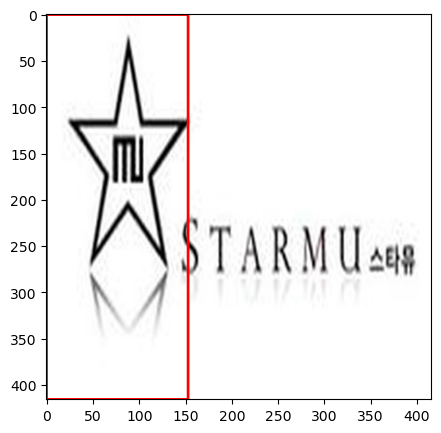

In [9]:
def draw_boxes_on_image(image_path, filename):
    # 이미지 불러오기
    image = Image.open(image_path)
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # bbox_values, vienna_code 만들기
    bbox_values = train[train['fileName'] == filename]['bbox'].values[0]
    vienna_code = train[train['fileName'] == filename]['Vienna_Code'].values[0]

    x, y, width, height = bbox_values

    # Calculate the coordinates of the bounding box
    x_min, y_min = max(0,int(x)), max(0,int(y))
    x_max, y_max = min(416, int(x + width)), min(416, int(y + height))

    # 이미지에 바운딩 박스 그리기
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    cv2.putText(image, str(vienna_code), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 이미지와 바운딩 박스 출력
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.show()

    
# 파일 경로 설정 (use raw string to handle backslashes)
image_name = '010102_4020150024077.jpg'
image_file = rf'D:/상표 이미지 및 텍스트/Training/data/yolo/train/{image_name}'

# 함수 실행
draw_boxes_on_image(image_path = image_file, filename = image_name)

- 그 밖에 특이한 경우 확인

In [25]:
train[(train['bbox'].apply(lambda x: x == [-375.51, -37.8, 529.32, 459.89]))]

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna_Code,category_id,supercategory,Code_Index
4021,173056,False,4020150024077,"[-375.51, -37.8, 529.32, 459.89]",4f9m61c04zrlfkp2h45gl,하나의 별,010102_4020150024077.jpg,416,416,010102,1,하나의 별,0


In [10]:
train[train['name'] == '가지, 오이, 피클용 오이, 파프리카']

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna_Code,category_id,supercategory,Code_Index
703984,173056,False,1192864,"[18.6, 12.34, 122.19, 132.29]",s0gkzlxwaajrk7wfx7m4t,"가지, 오이, 피클용 오이, 파프리카",050915_1192864.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
703985,173056,False,1408687,"[352.57, 2.94, 35.33, 116.79]",8s8z520jf6l5mbmugzt3mr,"가지, 오이, 피클용 오이, 파프리카",050915_1408687.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
703986,173056,False,1477933,"[49.41, 144.46, 49.71, 75.46]",ryrgdz7uodfh3vqhk2s26v,"가지, 오이, 피클용 오이, 파프리카",050915_1477933.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
703987,173056,False,4019800003282,"[63.16, 14.11, 293.64, 408.17]",9rwh0tomfhgeip26f3a1j,"가지, 오이, 피클용 오이, 파프리카",050915_4019800003282.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
703988,173056,False,4019900028741,"[162.59, 168.16, 118.69, 67.04]",5oklb586x7ya2c7i2dbrj9,"가지, 오이, 피클용 오이, 파프리카",050915_4019900028741.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
704415,173056,False,4120080013327,"[190.71, 101.2, 111.11, 93.57]",45b5d7d3d96840eda0aeb1,"가지, 오이, 피클용 오이, 파프리카",050915_4120080013327.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
704416,173056,False,4120090025269,"[270.41, 185.79, 11.59, 10.44]",31c6e2d2a2de4ba095baa9,"가지, 오이, 피클용 오이, 파프리카",050915_4120090025269.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
704417,173056,False,4120090025269,"[260.03, 189.19, 12.46, 7.3]",7d8d39a9767e4800907837,"가지, 오이, 피클용 오이, 파프리카",050915_4120090025269.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146
704418,173056,False,4120100033833,"[242, 234.45, 38.04, 86.32]",e39181b164de478bbad9f9,"가지, 오이, 피클용 오이, 파프리카",050915_4120100033833.jpg,416,416,050915,1,"가지, 오이, 피클용 오이, 파프리카",146


In [51]:
train[train['Vienna Code'] == 20723]

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna Code,category_id,supercategory
211491,173056,False,1003045,"[16.72, 93.3, 402.2, 131.72]",8dmajjiahhjw6brx0d83re,도안화(양식화)된 사람들의 그룹,020723_1003045.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
211492,173056,False,1062036,"[93.87, -3.17, 192.63, 427.56]",93kooclzt6d3a99ek5w7r7,도안화(양식화)된 사람들의 그룹,020723_1062036.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
211493,173056,False,1062036,"[75.39, 171.22, 32.11, 152.65]",8xelw0zseb681dhlm9ml1b,도안화(양식화)된 사람들의 그룹,020723_1062036.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
211494,173056,False,1062036,"[269.56, 160.69, 41.01, 138.62]",loqiy3uww1arbcxqpqyvg,도안화(양식화)된 사람들의 그룹,020723_1062036.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
211495,173056,False,1101639,"[166.6, 187.24, 250.31, 90.94]",zpnieqwoj7qrtvi106m73s,도안화(양식화)된 사람들의 그룹,020723_1101639.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
...,...,...,...,...,...,...,...,...,...,...,...,...
213165,173056,False,4120080014858,"[109.83, 101.51, 211.23, 176.19]",92a17586b10e41a0a9b604,도안화(양식화)된 사람들의 그룹,020723_4120080014858.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
213166,173056,False,4120080028698,"[37.18, 181.6, 53.13, 57.22]",e45c64f3a64141b8a7d6c3,도안화(양식화)된 사람들의 그룹,020723_4120080028698.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
213167,173056,False,4120080028988,"[95.84, 166.8, 54.33, 47.75]",883e895921cf40f28f203f,도안화(양식화)된 사람들의 그룹,020723_4120080028988.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹
213168,173056,False,4120090022645,"[160.87, 117.87, 99.9, 82.43]",8a6a4c1ecd124146ae1144,도안화(양식화)된 사람들의 그룹,020723_4120090022645.jpg,416,416,20723,1,도안화(양식화)된 사람들의 그룹


In [59]:
train[train['image_id'] == '4020180169711']

,area,iscrowd,image_id,bbox,id,name,fileName,height,width,Vienna Code,category_id,supercategory
5661,173056,False,4020180169711,"[183.61, 1.41, 87.66, 264.38]",0z0amgm73rn8nfw4yc79dh,하나의 별,010102_4020180169711.jpg,416,416,10102,1,하나의 별
37667,173056,False,4020180169711,"[187.47, -4.43, 95.84, 270.84]",62tzpsf7y4kua0sxh04hx,꼭지점이 불균등한 별 [Note] 꼭지점이 불균등한 별로 구성된 스파크를 포함,010112_4020180169711.jpg,416,416,10112,1,꼭지점이 불균등한 별 [Note] 꼭지점이 불균등한 별로 구성된 스파크를 포함
1967771,173056,False,4020180169711,"[185.79, 0.05, 91.83, 384.03]",eirhlhnv8ng5vt6da4pg9g,"크기가 다른 기호(부호, 표시) 밑에 도시된 글자 [Note] 예를들어 불균형의 점...",270507_4020180169711.jpg,416,416,270507,1,"크기가 다른 기호(부호, 표시) 밑에 도시된 글자 [Note] 예를들어 불균형의 점..."
2167544,173056,False,4020180169711,"[330.26, 45.32, 94.99, 392.34]",zxh6b1vpe3s6amvqdi4peq,도형화(디자인화)된 \'A\',270901_4020180169711.jpg,416,416,270901,1,도형화(디자인화)된 \'A\'
2167545,173056,False,4020180169711,"[52.83, 48.54, 93.1, 389.15]",bo3xdx7lkt22t4n016ftx,도형화(디자인화)된 \'A\',270901_4020180169711.jpg,416,416,270901,1,도형화(디자인화)된 \'A\'
2273253,173056,False,4020180169711,"[183.15, -12.02, 90.52, 389.2]",n2uoy1nnrtki50epv7zy79,도형화(디자인화)된 \'I\',270909_4020180169711.jpg,416,416,270909,1,도형화(디자인화)된 \'I\'
